# Uniform Data Evaluation Notebook

### Imports and Settings

In [1]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

In [23]:
import numpy as np
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)

from tueplots import bundles
from tueplots import axes
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams.update(**bundles.neurips2022(usetex=False, nrows=2), **axes.lines(base_width=0.5), **{"figure.dpi": 150})

from neural_ot.data import get_paired_unbalanced_uniform_samplers
from neural_ot.utils import get_neural_dual_from_ckpt

## Util Functions

In [20]:
def plot_data(source, target):
    """Plot data."""

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2.0))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2.0))

    ax.scatter(target[:, 0], target[:, 1], color='red',
               alpha=0.2, label=r'$target$')
    ax.scatter(source[:, 0], source[:, 1], color='blue',
               alpha=0.2, label=r'$source$')
    plt.axis('equal')
    plt.xlim(-1, 6)
    plt.ylim(-2, 2)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend(fontsize=10)

In [33]:
def plot_ot_map(neural_dual, source, target, inverse=False):
    """Plot data and learned optimal transport map."""

    def draw_arrows(a, b):
        plt.arrow(a[0], a[1], b[0] - a[0], b[1] - a[1],
                  color=[0.5, 0.5, 1], alpha=0.3)
        
    if not inverse:
        grad_state_s = neural_dual.transport(source)
    else:
        grad_state_s = neural_dual.inverse_transport(target)
    # Apply dimensionality reduction
    if inverse:
        intermediate_source = source
        source = target
        target = intermediate_source
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2.0))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2.0))
    
    ax.scatter(target[:, 0], target[:, 1], color='#A7BED3',
               alpha=0.5, label=r'$target$')
    ax.scatter(source[:, 0], source[:, 1], color='#1A254B',
               alpha=0.5, label=r'$source$')
    if not inverse:
        ax.scatter(grad_state_s[:, 0], grad_state_s[:, 1], color='#F2545B',
               alpha=0.5, label=r'$\nabla g(source)$')
    else:
        ax.scatter(grad_state_s[:, 0], grad_state_s[:, 1], color='#F2545B',
                   alpha=0.5, label=r'$\nabla f(target)$')
    
    #plt.legend(bbox_to_anchor=(0.5, 1.1), loc="center", ncol = 3, fontsize=10)
    plt.legend(fontsize=10)
    plt.xlim(-1, 6)
    plt.ylim(-2, 2)
    plt.gca().set_aspect('equal', adjustable='box')
    for i in range(grad_state_s.shape[0]):
        draw_arrows(source[i, :], grad_state_s[i, :])
    plt.savefig('uniform_tau0.99.png', bbox_inches='tight')

In [35]:
def plot_potential_map(neural_dual, data, embedding, inverse=False):
    """Plot data and learned potential."""
    if not inverse:
        potential = jax.vmap(lambda x: neural_dual.g.apply_fn({'params': neural_dual.g.params}, x))(data)
    else:
        potential = jax.vmap(lambda x: neural_dual.f.apply_fn({'params': neural_dual.f.params}, x))(data)
        
    potential = 1/2 * (jnp.linalg.norm(data, axis=1) ** 2) - potential
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2.0))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2.0))
    ax.tricontour(embedding[:, 0], embedding[:, 1], potential)
    ax.scatter(embedding[:, 0], embedding[:, 1], c=potential, alpha=0.25)
    plt.xlim(-1, 6)
    plt.ylim(-2, 2)
    plt.gca().set_aspect('equal', adjustable='box')
    #plt.savefig('potential_tau0.98.png', bbox_inches='tight')

In [38]:
def get_2dmgrid(num_points, x_start, x_stop, y_start, y_stop):
    """Creates an evenly-spaced 2d meshgrid"""
    x = np.linspace(x_start, x_stop, num_points)
    y = np.linspace(y_start, y_stop, num_points)
    xv, yv = np.meshgrid(x, y)
    xv = np.reshape(xv, [-1])
    yv = np.reshape(yv, [-1])
    mgrid = np.stack([xv, yv]).T
    return mgrid

## Get trained model

In [51]:
# params
input_dim = 2
first_quadratic_term = False
first_quadratic = True
ckpt_dir = "../neural_ot/runs/ckpts/uniform_unbalanced/makkuva_pretrain_eps1_tau0.99/best"

In [52]:
# create and load neural dual
neural_dual = get_neural_dual_from_ckpt(
    ckpt_dir=ckpt_dir,
    first_quadratic_term=first_quadratic_term,
    first_quadratic=first_quadratic,
    input_dim=input_dim)

## Get Data

In [17]:
# params
num_samples = 120
batch_size = 1024

In [18]:
key = jax.random.PRNGKey(0)
_, _, _, loader_source, loader_target = get_paired_unbalanced_uniform_samplers(
    key=key, input_dim=input_dim, batch_size=batch_size, num_samples=num_samples
)

In [19]:
data_source = loader_source(None, full_dataset=True)
data_target = loader_target(None, full_dataset=True)
len_data_source = len(data_source)
len_data_target = len(data_target)
print(len_data_source, len_data_target)
data = np.concatenate([data_source, data_target], axis=0)

300 300


In [42]:
# Get 2D meshgrid, adjust for desired coordinates
mgrid = get_2dmgrid(num_points=50, x_start=-1, x_stop=6, y_start=-2, y_stop=2)

# Map to high dim embedding
high_dim_embedding = mgrid
# Map backwards to low dim and plot
low_dim_emb = mgrid

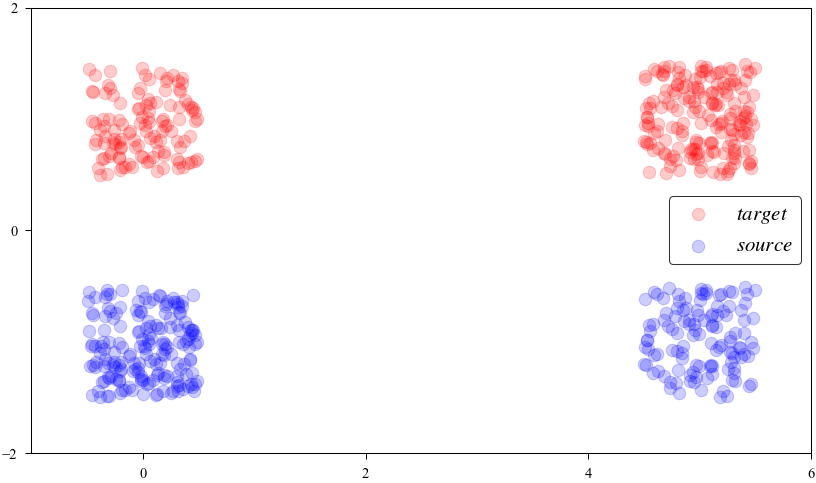

In [24]:
plot_data(data_source, data_target)

# Standard Neural OT

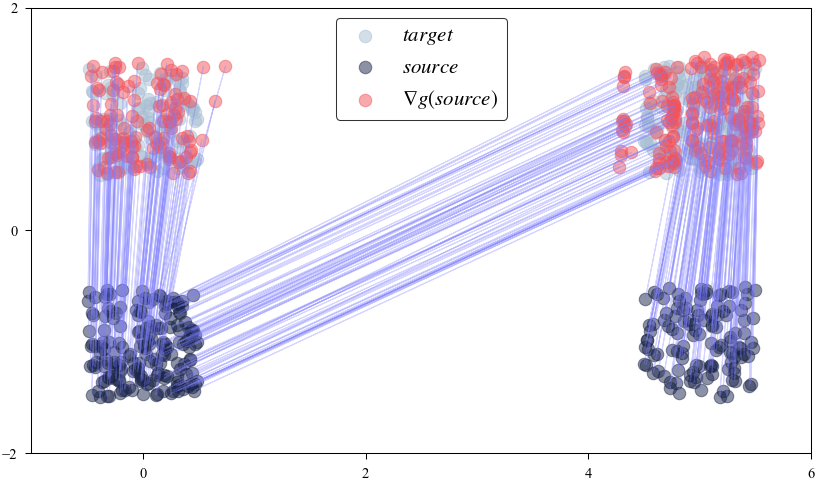

In [29]:
plot_ot_map(neural_dual, data_source, data_target, inverse=False)

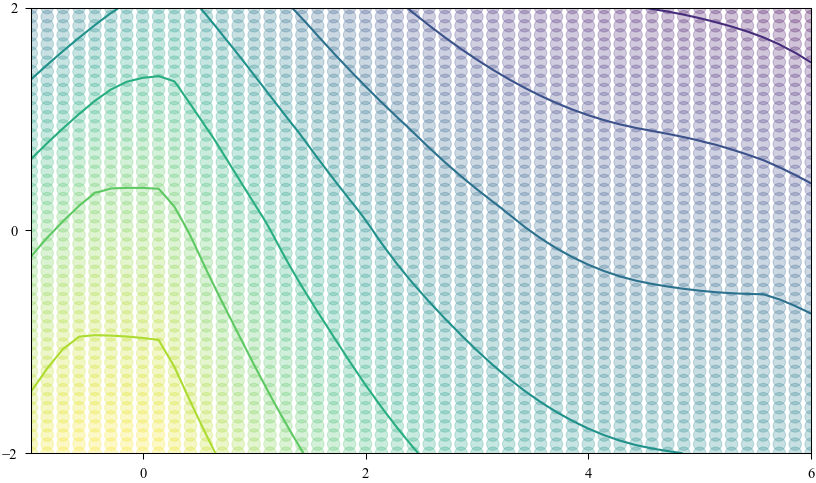

In [41]:
plot_potential_map(neural_dual, high_dim_embedding, mgrid, inverse=False)

# Tau=1.0 Eps=1.0

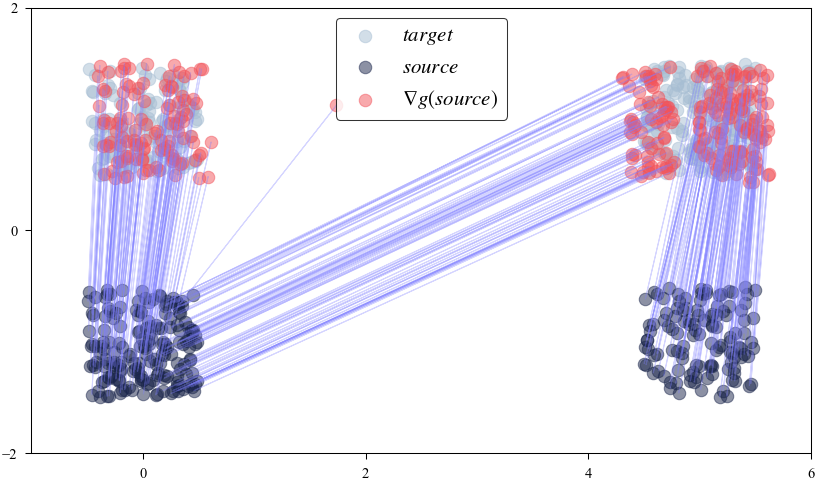

In [49]:
plot_ot_map(neural_dual, data_source, data_target, inverse=False)

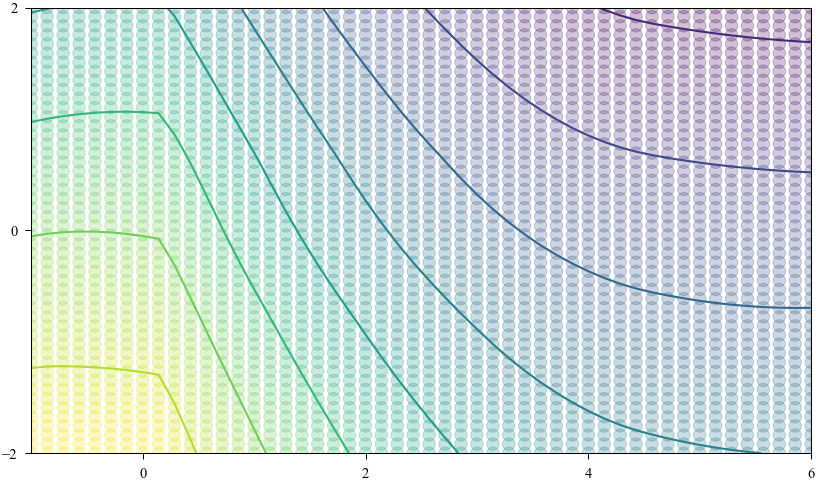

In [50]:
plot_potential_map(neural_dual, high_dim_embedding, mgrid, inverse=False)

# Tau=0.99 Eps=1.0

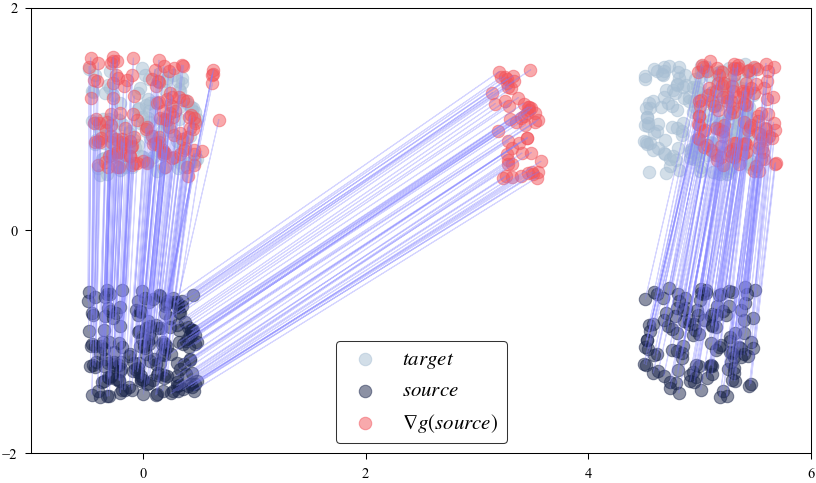

In [53]:
plot_ot_map(neural_dual, data_source, data_target, inverse=False)

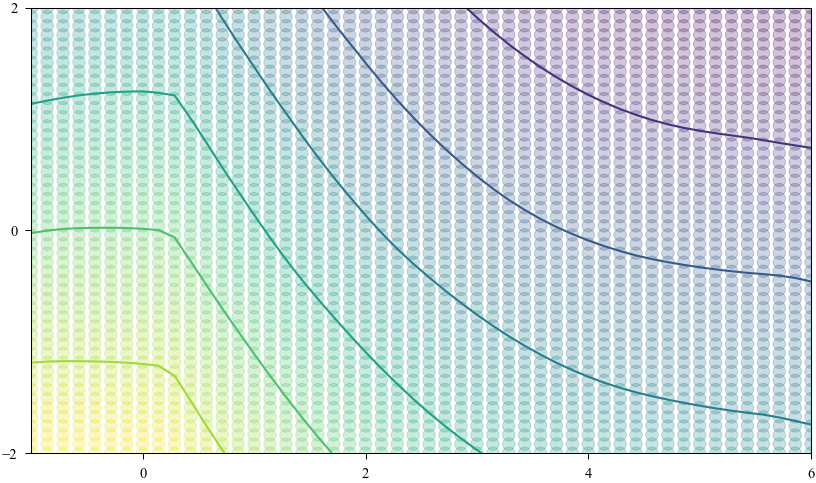

In [54]:
plot_potential_map(neural_dual, high_dim_embedding, mgrid, inverse=False)

# Tau=0.9 Eps=1.0

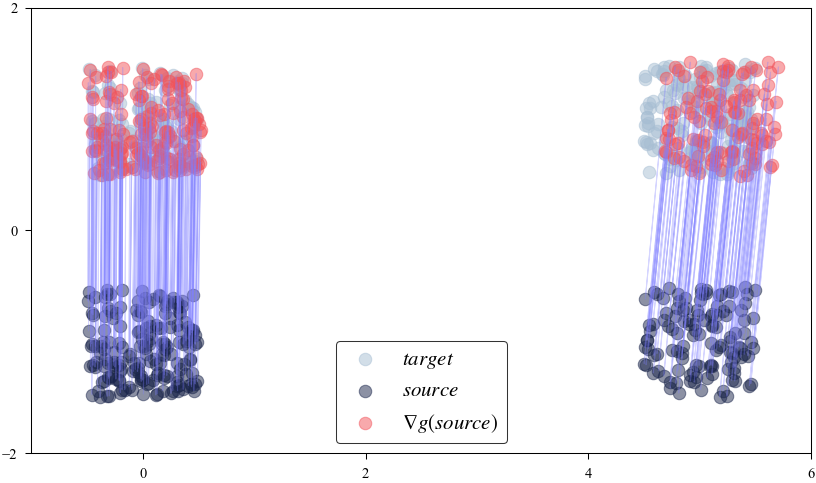

In [45]:
plot_ot_map(neural_dual, data_source, data_target, inverse=False)

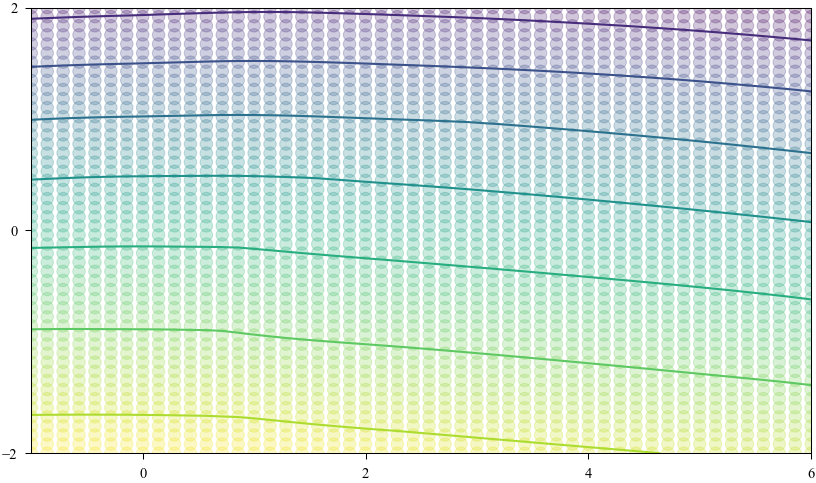

In [46]:
plot_potential_map(neural_dual, high_dim_embedding, mgrid, inverse=False)